## Statistics of Inverse design using gradient opt
---

## Import modules

In [1]:
import tensorflow as tf
import os
import sys
import ast
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import time

2025-01-07 14:58:58.361130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 14:58:58.368928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 14:58:58.377581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 14:58:58.380235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 14:58:58.386809: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


I0000 00:00:1736258347.113814   19404 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736258347.138643   19404 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736258347.142075   19404 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load runtime

In [3]:
'''
##########################################################################################
####################### Load the runtimes  DataFrame #####################################
##########################################################################################
'''
with open('runtime/newData_122500/04_testSetNew_04fwdHybrid_03wgangp_LrFixed_0.01_100iter_500latent_runtime_2500.pkl', 'rb') as f:
    loaded_runtimes = pickle.load(f)
    
loaded_runtimes.head()


,Sample,Runtime (seconds)
0,1,10.229598
1,2,9.341015
2,3,9.386319
3,4,9.476007
4,5,9.302303


In [4]:
# Sum the 'Runtime (seconds)' column
total_runtime = loaded_runtimes['Runtime (seconds)'].sum()
avr_runtime = loaded_runtimes['Runtime (seconds)'].mean()


print("Total Runtime (seconds):", total_runtime)
print("Total avr_runtime (seconds):", avr_runtime)


Total Runtime (seconds): 23156.03778028488
Total avr_runtime (seconds): 9.262415112113953


## Load test data and optimized from inverse design gradient-based

In [6]:
'''
##########################################################################################
####################### Load the Sample and Optimized  DataFrame #########################
##########################################################################################
'''

hdf5_df_file = "datasets/newData_122500/02_h5_wide_122500_df_test_with_pred.h5"   # depend on what test set that forward model evalaute on
df_test = pd.read_hdf(hdf5_df_file)
df_test.head() # 2500 samples 

with open('best_geometries/newData_122500/04_bestgeo_testSetNew_04fwdHybrid_03wgangp_LrFixed_0.01_100iter_500latent_122500.pkl', 'rb') as f:
    final_best_geometries_df = pickle.load(f)
    
final_best_geometries_df.head()


,mat_core,mat_shell,r_core,r_shell,Total Loss,Sample,predicted_Qfwd,predicted_Qback,mie_Qfwd,mie_Qback,log_Qfwd,log_Qback
0,ZrO2,Si,39.0098,132.001175,0.000105,1,"[8.631038665771484, 7.775725364685059, 6.32042...","[0.6319594383239746, 0.4332268238067627, 0.577...","[8.630782989899382, 7.794431901905115, 6.22697...","[0.6438912892599531, 0.4468793096105164, 0.555...","[2.2649645298671146, 2.174118782800853, 1.9778...","[0.49706616869329767, 0.3694090368525297, 0.44..."
1,Au,Si3N4,65.060806,92.025742,0.000014,2,"[3.0469813346862793, 2.9093263149261475, 2.770...","[0.23665910959243774, 0.25492990016937256, 0.2...","[3.059369590298048, 2.9105291167305123, 2.7723...","[0.25210661204096785, 0.2638103163634552, 0.27...","[1.4010276882318864, 1.3636726888138098, 1.327...","[0.2248274224399174, 0.23413121829545913, 0.24..."
2,Si,Si,15.442053,31.99053,0.000002,3,"[1.1245956420898438, 0.8348767161369324, 0.603...","[0.12740163505077362, 0.038365479558706284, 0....","[1.158339922142123, 0.8287948272570484, 0.6168...","[0.12123727777188192, 0.038268089961561405, 0....","[0.7693393716427733, 0.6036571855641686, 0.480...","[0.1144327878577185, 0.037554026889157266, 0.0..."
3,ZrO2,ZrO2,22.564852,114.021439,0.000003,4,"[19.129209518432617, 16.13593101501465, 14.337...","[1.997433066368103, 1.6007797718048096, 1.4216...","[19.222147978120923, 16.185515852286997, 14.29...","[2.0139528002976057, 1.6094054523188521, 1.407...","[3.006778438322234, 2.844066927441444, 2.72768...","[1.1032524399282666, 0.959122399338725, 0.8784..."
4,Au,TiO2,49.097099,76.084763,0.000059,5,"[6.334540367126465, 6.767282009124756, 6.94309...","[1.5601356029510498, 1.434265375137329, 1.2467...","[6.55676915342881, 6.8150888067552176, 7.02224...","[1.6031477642302185, 1.471005641431433, 1.3156...","[2.0224437381892852, 2.0560563274371813, 2.082...","[0.9567213912972223, 0.9046252100598899, 0.839..."


## Inverse Design Statistics

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Convert relevant columns from DataFrame to NumPy arrays
qfwd_target = np.vstack(df_test["Q_fwd"])  # Target values from test set
qfwd_mie = np.vstack(final_best_geometries_df["mie_Qfwd"])  # Mie values from optimized geometries

qback_target = np.vstack(df_test["Q_back"])  # Target values from test set
qback_mie = np.vstack(final_best_geometries_df["mie_Qback"])  # Mie values from optimized geometries

# Calculate performance metrics
# Qfwd and Qback
mse_Qfwd = np.abs(qfwd_target - qfwd_mie) ** 2  # Mean squared error per sample
mae_Qfwd = np.abs(qfwd_target - qfwd_mie)  # Mean absolute error per sample

mse_Qback = np.abs(qback_target - qback_mie) ** 2  # Mean squared error per sample
mae_Qback = np.abs(qback_target - qback_mie)  # Mean absolute error per sample


# Print the results
print(f"Inverse Design Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

Inverse Design Performance for Qfwd:
Mean Absolute Error (MAE): 0.060804
Mean Squared Error (MSE): 0.259664

Test Set Performance for Qback:
Mean Absolute Error (MAE): 0.029125
Mean Squared Error (MSE): 0.062527


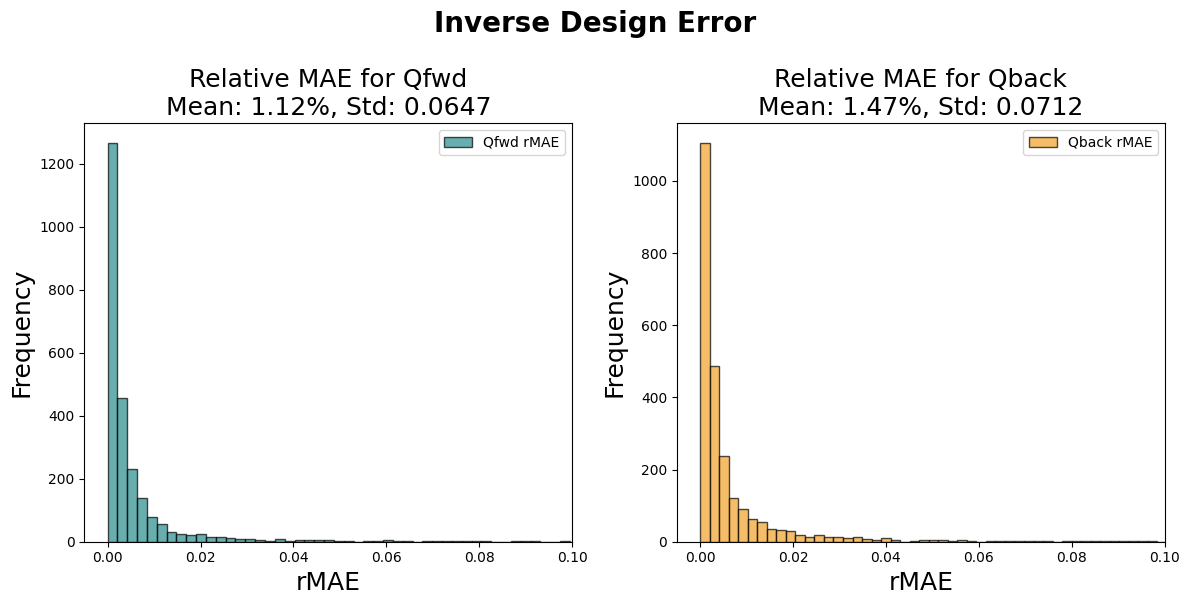

In [8]:
# Absolute percentage error (MAPE)
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_target.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_target.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Inverse Design Error", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=700,
    color="#298c8cff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=600,
    color="#f1a226ff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

plt.tight_layout()
# Save the plot as a PDF file in vector format
# plt.savefig('save_figures/new_plot/gradient_statistics.svg', bbox_inches='tight')
plt.show()


In [9]:
final_best_geometries_df.head()

,mat_core,mat_shell,r_core,r_shell,Total Loss,Sample,predicted_Qfwd,predicted_Qback,mie_Qfwd,mie_Qback,log_Qfwd,log_Qback
0,ZrO2,Si,39.0098,132.001175,0.000105,1,"[8.631038665771484, 7.775725364685059, 6.32042...","[0.6319594383239746, 0.4332268238067627, 0.577...","[8.630782989899382, 7.794431901905115, 6.22697...","[0.6438912892599531, 0.4468793096105164, 0.555...","[2.2649645298671146, 2.174118782800853, 1.9778...","[0.49706616869329767, 0.3694090368525297, 0.44..."
1,Au,Si3N4,65.060806,92.025742,0.000014,2,"[3.0469813346862793, 2.9093263149261475, 2.770...","[0.23665910959243774, 0.25492990016937256, 0.2...","[3.059369590298048, 2.9105291167305123, 2.7723...","[0.25210661204096785, 0.2638103163634552, 0.27...","[1.4010276882318864, 1.3636726888138098, 1.327...","[0.2248274224399174, 0.23413121829545913, 0.24..."
2,Si,Si,15.442053,31.99053,0.000002,3,"[1.1245956420898438, 0.8348767161369324, 0.603...","[0.12740163505077362, 0.038365479558706284, 0....","[1.158339922142123, 0.8287948272570484, 0.6168...","[0.12123727777188192, 0.038268089961561405, 0....","[0.7693393716427733, 0.6036571855641686, 0.480...","[0.1144327878577185, 0.037554026889157266, 0.0..."
3,ZrO2,ZrO2,22.564852,114.021439,0.000003,4,"[19.129209518432617, 16.13593101501465, 14.337...","[1.997433066368103, 1.6007797718048096, 1.4216...","[19.222147978120923, 16.185515852286997, 14.29...","[2.0139528002976057, 1.6094054523188521, 1.407...","[3.006778438322234, 2.844066927441444, 2.72768...","[1.1032524399282666, 0.959122399338725, 0.8784..."
4,Au,TiO2,49.097099,76.084763,0.000059,5,"[6.334540367126465, 6.767282009124756, 6.94309...","[1.5601356029510498, 1.434265375137329, 1.2467...","[6.55676915342881, 6.8150888067552176, 7.02224...","[1.6031477642302185, 1.471005641431433, 1.3156...","[2.0224437381892852, 2.0560563274371813, 2.082...","[0.9567213912972223, 0.9046252100598899, 0.839..."


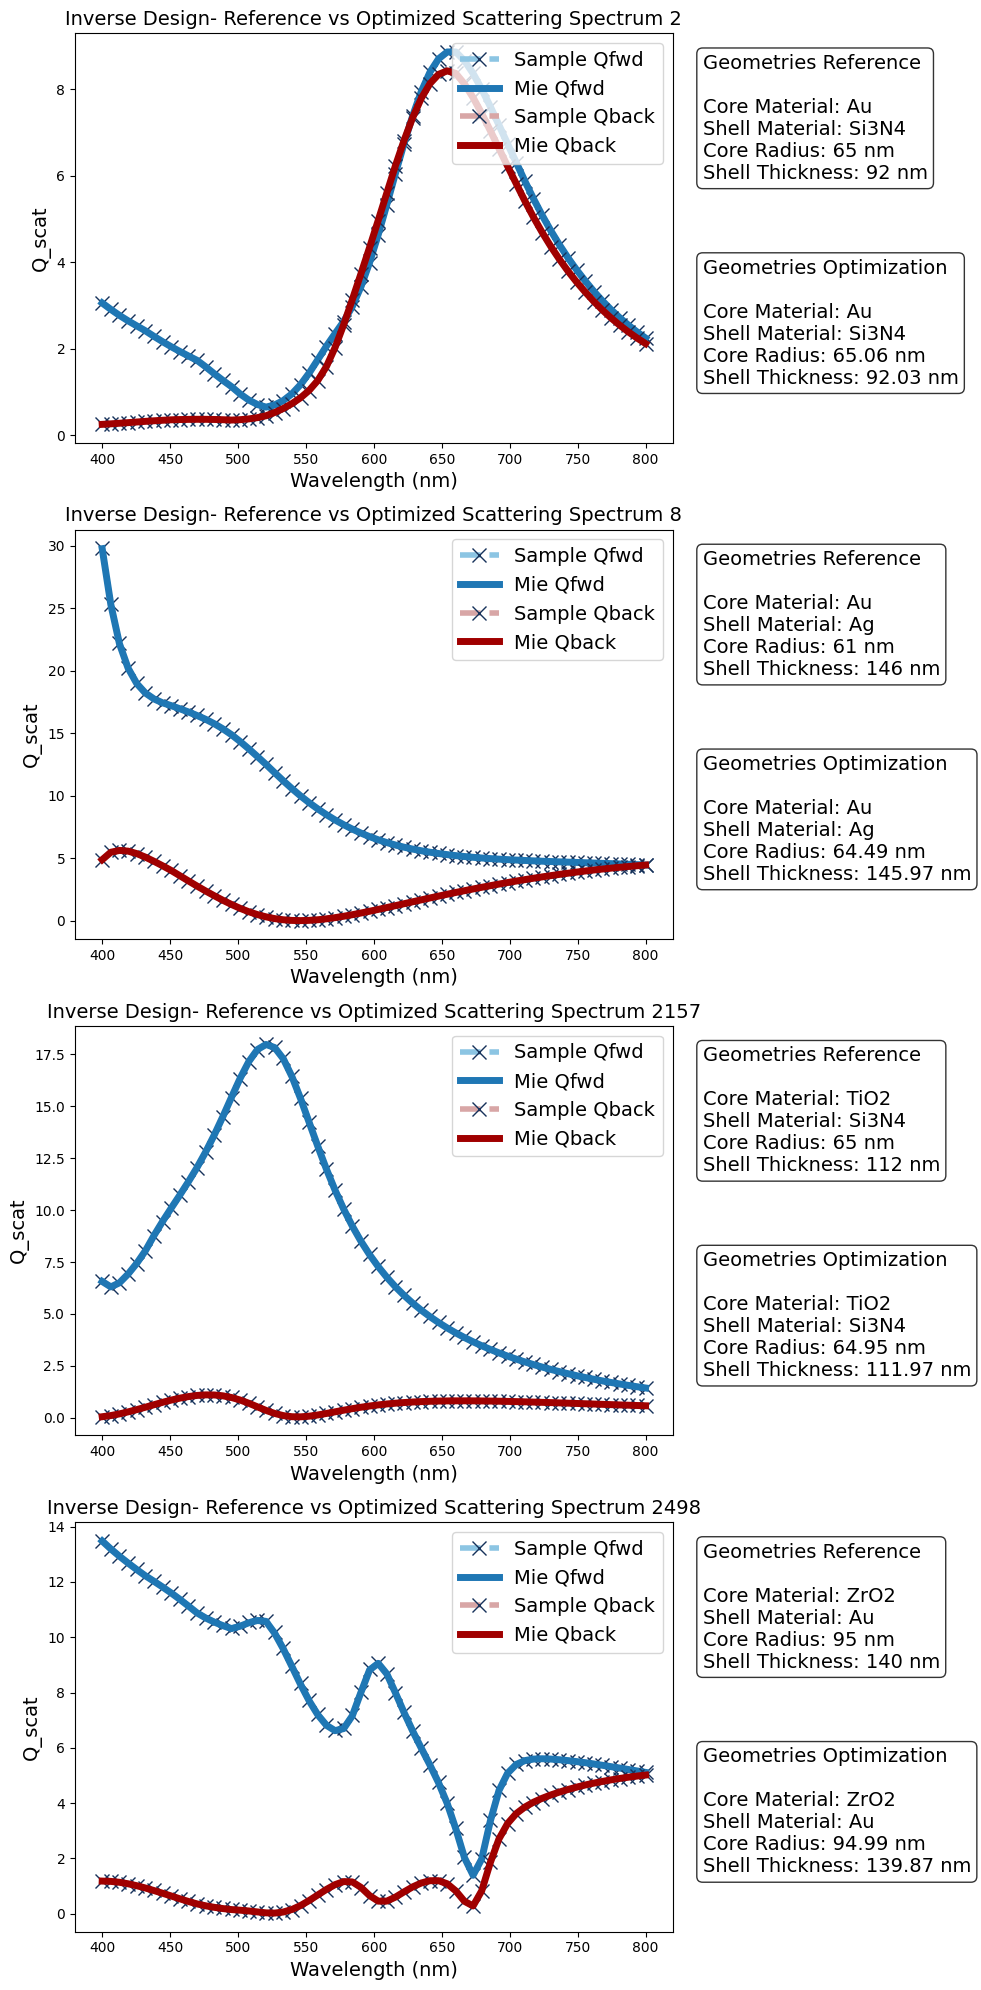

In [13]:
import numpy as np
import matplotlib.pyplot as plt


wavelengths = np.linspace(400, 800, 64)  # From 400 nm to 800 nm
wavelengths_new = np.linspace(400, 800, 64)

sample_indices = [1,7,2156,2497]

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))  

# Loop through the sample indices and generate the plots
for idx, sample_idx in enumerate(sample_indices):

    # Extract the relevant values from the best_geometries DataFrame for the optimized geometry
    core_material_optimized = final_best_geometries_df['mat_core'].values[sample_idx]
    shell_material_optimized = final_best_geometries_df['mat_shell'].values[sample_idx]
    core_radius_optimized = final_best_geometries_df['r_core'].values[sample_idx]
    shell_thickness_optimized = final_best_geometries_df['r_shell'].values[sample_idx]

    # Plot Qfwd on the left (first column)
    axes[idx].plot(wavelengths, df_test['Q_fwd'].iloc[sample_idx], label="Sample Qfwd", marker='x',markersize = 10, color='#8cc5e3ff', linestyle='--', markerfacecolor='#16325bff', markeredgecolor='#16325bff',
     linewidth=4)
    axes[idx].plot(wavelengths_new, final_best_geometries_df['mie_Qfwd'].iloc[sample_idx], label="Mie Qfwd", markersize = 8, color='#1f77b4ff',  linewidth=5)

    # Annotate the plot with the core material, shell material, core radius, and shell thickness
    annotation_text_sample = (f"Geometries Reference\n\n"
                              f"Core Material: {df_test['mat_core'].iloc[sample_idx]}\n"
                              f"Shell Material: {df_test['mat_shell'].iloc[sample_idx]}\n"
                              f"Core Radius: {df_test['r_core'].iloc[sample_idx]} nm\n"
                              f"Shell Thickness: {df_test['r_shell'].iloc[sample_idx]} nm")

    axes[idx].annotate(annotation_text_sample, xy=(1.05, 0.95), xycoords='axes fraction', fontsize=14,
                                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8),
                                 verticalalignment='top')

    # Annotate the plot for optimized geometry
    annotation_text_optimized = (f"Geometries Optimization\n\n"
                                 f"Core Material: {core_material_optimized}\n"
                                 f"Shell Material: {shell_material_optimized}\n"
                                 f"Core Radius: {core_radius_optimized:.2f} nm\n"
                                 f"Shell Thickness: {shell_thickness_optimized:.2f} nm")

    axes[idx].annotate(annotation_text_optimized, xy=(1.05, 0.45), xycoords='axes fraction', fontsize=14,
                                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8),
                                 verticalalignment='top')

    axes[idx].set_xlabel('Wavelength (nm)', fontsize=14)
    axes[idx].set_ylabel('Q_scat', fontsize=14)
    axes[idx].legend(fontsize=14, loc='upper right', frameon=True)

    axes[idx].plot(wavelengths, df_test['Q_back'].iloc[sample_idx], label="Sample Qback", marker='x', markersize = 10, color='#d8a6a6ff', linestyle='--', markerfacecolor='#16325bff', markeredgecolor='#16325bff',
     linewidth=4)
    axes[idx].plot(wavelengths_new, final_best_geometries_df['mie_Qback'].iloc[sample_idx], label="Mie Qback", markersize = 8, color='#a00000ff', linewidth=5)

    axes[idx].set_xlabel('Wavelength (nm)', fontsize=14)
    axes[idx].set_title(f'Inverse Design- Reference vs Optimized Scattering Spectrum {sample_idx + 1}', fontsize=14)
    axes[idx].legend(fontsize=14, loc='upper right', frameon=True)


plt.tight_layout()
# plt.savefig("save_figures/new_plot/100iter_LRFixed_optimized_entire_spectrum.svg")
plt.show()
